In [1]:
import gfc
from gfc import *
import numpy as np
import scipy as sp
from scipy.stats import chi2
import copy as cp
from extreme_deconvolution import extreme_deconvolution as xd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gs
from matplotlib.patches import Ellipse
import matplotlib as mpl
from mcmcplotting import convert_to_stdev_nan
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle
from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, astrometryToPhaseSpace, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

In [2]:
root_folder = "/disks/strw9/vanweenen/mrp1/results/simulation"

# Simulate a collection of stars distributed at constant space density around the sun, 
# with distances between 1 and 500 pc. Use Galactic coordinates. Each star is assigned
# a 3D space velocity drawn from a superposition of several 3D normal distributions in 
# velocity space.
rmin = 1. #pc
rmax = 500. #pc
N = 50000 #nr of stars

r = np.random.uniform(rmin**3, rmax**3, N)**(1./3.) #pc
theta = np.arccos(np.random.uniform(-1, 1, N))-np.pi/2
phi = np.random.uniform(0, 2*np.pi, N)

x_gal,y_gal,z_gal = sphericalToCartesian(r, phi, theta)

In [3]:
# Use parameters from Bovy 2009 as initial velocity distribution.
amps_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_amps.npy')
means_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_means.npy')
covs_Bovy = gfc.io.load('/disks/strw9/vanweenen/mrp1/gfc/Bovy_parameters/' + 'Bovy_covs.npy')

amps_Bovy /= np.sum(amps_Bovy[:10])

K = 10
Kmin=1 ; Kmax=20 ; Kstep=1
wmin = 0.5 ; wmax=15 ; wstep=1.
#wmin = 0.5 ; wmax=5 ; wstep=.25

initamps = []
initmeans = []
initcovs = []

for k in range(len(amps_Bovy)):
    initamps.append(amps_Bovy[:k+1])
    initmeans.append(means_Bovy[:k+1])
    initcovs.append(covs_Bovy[:k+1])

print len(initamps[K-1])
#print initamps, initmeans, initcovs
print initamps[K-1], initmeans[K-1], initcovs[K-1]

# Simulate velocity for every star
component = np.random.choice(K, N, p=initamps[K-1]) #choose component
uvw_gal = np.empty([N,3])
for i in range(N):
    uvw_gal[i] = np.random.multivariate_normal(initmeans[K-1][component[i],:], initcovs[K-1][component[i],:,:])

10
[0.23917608 0.22777722 0.22617738 0.08909109 0.08509149 0.06739326
 0.03979602 0.01739826 0.00719928 0.00089991] [[   5.54   -6.97   -9.26]
 [ -22.72  -10.24   -7.3 ]
 [ -12.92  -29.57   -7.6 ]
 [ -19.43  -32.9    -4.93]
 [   9.2     3.89   -5.99]
 [ -17.79  -22.69   -4.51]
 [  -9.07  -20.5    -4.88]
 [ -40.07  -18.92    0.64]
 [ -28.28 -105.62    2.87]
 [   2.08 -103.07   -8.2 ]] [[[ 7.000e+02 -1.110e+02 -6.000e+01]
  [-1.110e+02  2.000e+02  2.500e+01]
  [-6.000e+01  2.500e+01  1.450e+02]]

 [[ 2.430e+02  7.000e+01  1.000e+01]
  [ 7.000e+01  4.800e+01  1.000e+01]
  [ 1.000e+01  1.000e+01  4.000e+01]]

 [[ 1.836e+03  5.500e+01 -6.000e+01]
  [ 5.500e+01  6.700e+02 -3.000e+01]
  [-6.000e+01 -3.000e+01  5.400e+02]]

 [[ 3.500e+02  1.650e+02  1.100e+02]
  [ 1.650e+02  2.300e+02  1.100e+02]
  [ 1.100e+02  1.100e+02  1.350e+02]]

 [[ 8.000e+01 -3.000e+01 -2.000e+01]
  [-3.000e+01  2.500e+01  9.000e+00]
  [-2.000e+01  9.000e+00  5.000e+01]]

 [[ 7.000e+01 -3.000e+01 -4.500e+01]
  [-3.000e+

In [4]:
# Transform the simulated positions and velocities into astrometric observables and radial velocity in ICRS
print "Transformation to astrometric observables.."
x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x_gal, y_gal, z_gal)
u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(uvw_gal[:,0], uvw_gal[:,1], uvw_gal[:,2])
alpha, delta, parallax, mura, mudec, vrad = phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs) #rad, rad, mas, mas/yr, mas/yr, km/s
astr_true = np.column_stack((alpha, delta, parallax, mura, mudec, vrad))

print "Simulate measured values.."
#Simulate measured values using measurement errors
measurement_error = np.array([0.,0.,0.3,1.,1.,0])
measurement_covar = np.diag(measurement_error**2) #measurement errors
astr_measured = np.empty([N,6])
for i in range(N):
    astr_measured[i] = np.random.multivariate_normal(astr_true[i,:], measurement_covar, 1)
errors_measured = np.tile(measurement_error, (N,1))
corr_measured = np.tile(np.tile([0.],15), (N,1))

arr_astr = np.column_stack((astr_measured, errors_measured, corr_measured))
labels = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'vrad', 'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'vrad_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'ra_vrad_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'dec_vrad_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'parallax_vrad_corr', 'pmra_pmdec_corr', 'pmra_vrad_corr', 'pmdec_vrad_corr')
t_astr=Table(arr_astr, names=labels)

Transformation to astrometric observables..
Simulate measured values..


In [6]:
print "Projection.."
# Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
# (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
# velocity components.
t_astr_vrad0 = cp.copy(t_astr)
for i in ['ra', 'dec']:
    gfc.add_rad(t_astr_vrad0, i, u.rad, u.rad)
    gfc.add_rad(t_astr, i, u.rad, u.rad)

# Do not give radial velocity data to transformation
matrix.transformation(t_astr_vrad0)#, vrad_col = 'vrad')
warr_vrad0 = gfc.XD_arr(t_astr_vrad0, "w") #icrs
wcovar_vrad0 = gfc.XD_arr(t_astr_vrad0, "S") ; wcovar_vrad0[:,2,2] = 1e15
varr_vrad0 = gfc.XD_arr(t_astr_vrad0, "UVW")
proj_vrad0 = gfc.XD_arr(t_astr_vrad0, "R")

# Give radial velocity data to transformation
matrix.transformation(t_astr, vrad_col = 'vrad')
warr = gfc.XD_arr(t_astr, "w") #icrs
wcovar = gfc.XD_arr(t_astr, "S")
varr = gfc.XD_arr(t_astr, "UVW")
proj = gfc.XD_arr(t_astr, "R")

Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


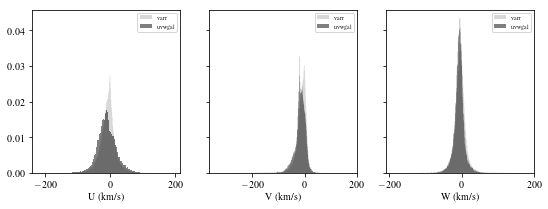

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(9,3))
velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
for v in range(len(velocities)):
    ax[v].hist(varr_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.3, label='varr')
    ax[v].hist(uvw_gal[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.5, label='uvwgal')
    ax[v].set_xlabel(velocities[v] + unit)
    ax[v].legend(loc='upper right', prop={'size': 6})
plt.show()

In [ ]:
# Perform XD
print "Perform XD.."
# The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
# The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).
wrange = np.arange(wmin, wmax + wstep, wstep)**2.
Krange = range(Kmin, Kmax + Kstep, Kstep) #Krange from Kmin to Kmax

logL, AIC, MDL, amps_test, means_test, covs_test, bestK, bestw = gfc.perform_XD(warr, wcovar, proj, initamps, initmeans, initcovs, wrange, Krange, N)
logL_vrad0, AIC_vrad0, MDL_vrad0, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, bestK_vrad0, bestw_vrad0 = gfc.perform_XD(warr_vrad0, wcovar_vrad0, proj, initamps, initmeans, initcovs, wrange, Krange, N)

Perform XD..
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
print "XD:"
print "logLikelihood: best K = {0}, best w = {1}".format(bestK[0], bestw[0])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[0], means_test[0], covs_test[0])
print "AIC: best K = {0}, best w = {1}".format(bestK[1], bestw[1])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[1], means_test[1], covs_test[1])
print "MDL: best K = {0}, best w = {1}".format(bestK[2], bestw[2])
print "amps: {0}, means: {1}, covs: {2}".format(amps_test[2], means_test[2], covs_test[2])

In [ ]:
gfc.io.save_PDFs(amps_test, means_test, covs_test, root_folder + '/vrad/')
gfc.io.save_PDFs(amps_test_vrad0, means_test_vrad0, covs_test_vrad0, root_folder + '/vrad0/')

In [ ]:
amps_test, means_test, covs_test = gfc.io.load_PDFs(root_folder + '/vrad/')
amps_test_vrad0, means_test_vrad0, covs_test_vrad0 = gfc.io.load_PDFs(root_folder + '/vrad0/')

In [ ]:
def plot_normal_PDF(ax, v, x, amps, means, covs, c, l):
    pdf = np.zeros(len(x))
    for n in range(len(amps)):
        pdf += amps[n]*sp.stats.norm.pdf(x, loc=means[n,v], scale=np.sqrt(covs[n,v,v]))
    ax.plot(x, pdf, label=l, color=c, lw=.8)

def plot_hist_uvw(inita, initm, initc, a_test, m_test, c_test, uvw_data, a_test_vrad0=None, m_test_vrad0=None, c_test_vrad0=None, uvw_data_vrad0=None, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors_vrad0 = ('red','dodgerblue','green') ; colors = ('lightcoral', 'skyblue', 'greenyellow')
    test = ('logL', 'AIC', 'MDL') ; test_vrad0 = ('logL $v_r = 0$', 'AIC $v_r = 0$', 'MDL $v_r = 0$')
    limits = ((-130, 120), (-120,60), (-70,70))
    
    fig, ax = plt.subplots(len(test), len(velocities), sharey=True, figsize=(9,9), tight_layout=True)
    for v in range(len(velocities)):
        vrange = np.linspace(limits[v][0], limits[v][1], len(uvw_data[:,v]))
        for t in range(len(test)):
            plot_normal_PDF(ax[t,v], v, vrange, a_test[t], m_test[t], c_test[t], colors[t], test[t]) #xd fit
            if a_test_vrad0 is not None:
                plot_normal_PDF(ax[t,v], v, vrange, a_test_vrad0[t], m_test_vrad0[t], c_test_vrad0[t], colors_vrad0[t], test_vrad0[t]) #xd fit without vrad info
            plot_normal_PDF(ax[t,v], v, vrange, inita, initm, initc, 'black', 'initial') #curve of initial velocity distribution
            ax[t,v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
            if uvw_data_vrad0 is not None:
                ax[t,v].hist(uvw_data_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.15, label='data $v_r = 0$')
            ax[t,v].set_xlabel(velocities[v] + unit)
            ax[t,v].set_xlim(limits[v])
            ax[t,v].legend(loc='upper right', prop={'size': 6})
    
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity'
    suptitle, filename = gfc.gplot.title_filename(suptitle, filename, *args)
    plt.suptitle(suptitle, y=1., fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()

def plot_hist_uvw2(inita, initm, initc, a_test, m_test, c_test, uvw_data, a_test_vrad0=None, m_test_vrad0=None, c_test_vrad0=None, uvw_data_vrad0=None, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors_vrad0 = ('red','dodgerblue','green') ; colors = ('lightcoral', 'skyblue', 'greenyellow')
    test = ('logL', 'AIC', 'MDL') ; test_vrad0 = ('logL $v_r = 0$', 'AIC $v_r = 0$', 'MDL $v_r = 0$')
    limits = ((-130, 120), (-120,60), (-70,70))
    
    fig, ax = plt.subplots(1, len(velocities), sharey=True, figsize=(9,4), tight_layout=True)
    for v in range(len(velocities)):
        vrange = np.linspace(limits[v][0], limits[v][1], len(uvw_data[:,v]))
        for t in range(len(test)):
            plot_normal_PDF(ax[v], v, vrange, a_test[t], m_test[t], c_test[t], colors[t], test[t]) #xd fit
            if a_test_vrad0 is not None:
                plot_normal_PDF(ax[v], v, vrange, a_test_vrad0[t], m_test_vrad0[t], c_test_vrad0[t], colors_vrad0[t], test_vrad0[t]) #xd fit without vrad info
        plot_normal_PDF(ax[v], v, vrange, inita, initm, initc, 'black', 'initial') #curve of initial velocity distribution
        ax[v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
        if uvw_data_vrad0 is not None:
            ax[v].hist(uvw_data_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.15, label='data $v_r = 0$')
        ax[v].set_xlabel(velocities[v] + unit)
        ax[v].set_xlim(limits[v])
        ax[v].legend(loc='upper right', prop={'size': 6})
    
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity'
    suptitle, filename = gfc.gplot.title_filename(suptitle, filename, *args)
    plt.suptitle(suptitle, y=1., fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()


In [ ]:
plot_hist_uvw(initamps[K-1], initmeans[K-1], initcovs[K-1], amps_test, means_test, covs_test, varr, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, varr_vrad0, 'Bovy')
plot_hist_uvw2(initamps[K-1], initmeans[K-1], initcovs[K-1], amps_test, means_test, covs_test, varr, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, varr_vrad0, 'Bovy')

In [ ]:
gfc.gplot.plot_XD_w_K(logL, AIC, MDL, bestK, bestw, False, Kmin, Kmax, wmin, wmax, 'Bovy')
gfc.gplot.plot_XD_w_K(logL_vrad0, AIC_vrad0, MDL_vrad0, bestK_vrad0, bestw_vrad0, True, Kmin, Kmax, wmin, wmax, 'Bovy')

In [ ]:
def KnownGroups(ax): #before: text
    ax.text(60, -90, "Arcturus")
    ax.plot([8, 57.5], [-105, -90], c='k', lw=2)
    ax.text(-80, -110, "Halo")
    ax.text(50, 40, "Sirius/UMa")
    ax.plot([49, 5], [40, 5], c='k', lw=2)
    ax.text(-100, 45, "Coma Berenices")
    ax.plot([-70, -10], [42, -5], c='k', lw=2)
    ax.text(-120, 34, "NGC 1901")
    ax.plot([-100, -25], [31, -12], c='k', lw=2)
    ax.text(-120, 0, "Hyades")
    ax.plot([-110, -45], [-3, -17], c='k', lw=2)
    ax.text(90, -50, "Pleiades")
    ax.plot([87, -15], [-45, -20], c='k', lw=2)
    ax.text(-125, -42, "Hercules")
    ax.plot([-93.5, -28], [-40, -42], c='k', lw=2)

def totalGaussians(axs, i, j, lsp, amps, means, covs):
    levels=np.array([2,6,12,21,33,50,68,80,90,95,99])/100.0
    xx, yy = np.meshgrid(lsp[j],lsp[i+1])
    pdfxy = np.zeros_like(xx)
    m = np.array([means[:,j], means[:,i+1]]).T
    c = np.array([[covs[:,j,j],covs[:,j,i+1]], [covs[:,i+1,j],covs[:,i+1,i+1]]]).T
    for k in range(len(amps)):
        pdfxy = pdfxy + amps[k] * \
        sp.stats.multivariate_normal.pdf(np.dstack((xx,yy)), mean=m[k], cov=c[k])
    axs[i+j].contour(lsp[j], lsp[i+1], convert_to_stdev_nan(np.log(pdfxy)), levels=levels, colors='k', linewidths=1)
                
def set_axes_3velocities(ax, limits):  
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    xpos = ('top', 'bottom') ; ypos = ('left', 'right')
    for i in range(2):
        for j in range(2):
            if j != i + 1:
                ax[i+j].set_xlim(limits[j]) ; ax[i+j].set_ylim(limits[i+1])
                ax[i+j].set_xlabel(velocities[j] + unit) ; ax[i+j].set_ylabel(velocities[i+1] + unit)
                ax[i+j].xaxis.set_label_position(xpos[i]) ; ax[i+j].yaxis.set_label_position(ypos[j])
    ax[0].xaxis.tick_top()
    ax[0].set_xticks((-100, -50, 0, 50, 100))
    ax[0].set_yticks((-100, -50, 0, 50))
    ax[2].yaxis.tick_right()

def plot_Gaussian_comps(amps, means, covs, t_uvw, total=False, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    filename = '/PDF'
    limits = ((-130, 120), (-120,60), (-70,70)); gs = (251, 181, 161)
    if total:
        filename += '_total'
        title = "Velocity distribution"
        #levels = np.logspace(-6.,-2.7,10)
        lsp = [np.linspace(limits[i][0], limits[i][1], gs[i]) for i in range(3)]
    else:
        line = ("xy", "xz", "yz") 
        title = "Gaussian components of velocity distribution"
    title, filename = gfc.gplot.title_filename(title, filename, *args)
    fig = plt.figure(figsize=(8,8))
    plt.suptitle(title)
    ax = [plt.subplot(2,1,1), plt.subplot(2,2,3), plt.subplot(2,2,4)]
    for i in range(2):
        for j in range(2):
            if j != i +1:
                if total:
                    totalGaussians(ax, i, j, lsp, amps, means, covs)
                else:
                    for a, m, c in zip(amps, means, covs):
                        gfc.gplot.draw_PDF_ellipse(ax[i+j], a, m, c, line[i+j], edgecolor="0.4")
                ax[i+j].hexbin(t_uvw[:,j], t_uvw[:,i+1], gridsize=gs[i+j], bins='log', mincnt=1, alpha=.4, lw=0.)
    set_axes_3velocities(ax, limits)    
    KnownGroups(ax[0])
    fig.savefig(saveto + filename)
    plt.show()

In [ ]:
plot_Gaussian_comps(amps_Bovy[:K], means_Bovy[:K], covs_Bovy[:K], uvw_gal, False, 'Bovy')
tests = ('XD', 'AIC', 'MDL')
for i in range(3):
    plot_Gaussian_comps(amps_test_vrad0[i], means_test_vrad0[i], covs_test_vrad0[i], varr, False, 'Bovy', tests[i])

In [ ]:
plot_Gaussian_comps(amps_Bovy[:K], means_Bovy[:K], covs_Bovy[:K], uvw_gal, True, 'Bovy')
tests = ('XD', 'AIC', 'MDL')
for i in range(3):
    plot_Gaussian_comps(amps_test_vrad0[i], means_test_vrad0[i], covs_test_vrad0[i], varr, True, 'Bovy', tests[i])

In [ ]:
pdfs_XD = map(gfc.pdf.multivariate, means_test_vrad0[0], covs_test_vrad0[0], amps_test_vrad0[0])
pdfs_AIC = map(gfc.pdf.multivariate, means_test_vrad0[1], covs_test_vrad0[1], amps_test_vrad0[1])
pdfs_MDL = map(gfc.pdf.multivariate, means_test_vrad0[2], covs_test_vrad0[2], amps_test_vrad0[2])
for i,row in enumerate(t_astr_vrad0):
    vrad_predicted_XD = gfc.radial_velocity_distribution(pdfs_XD, row["ra_rad"], row["dec_rad"], row["parallax"], row["pmra"], row["pmdec"], row["C"], t_astr['vrad_error'])
    print vrad_predicted_XD
for i,row in enumerate(t_astr_vrad0):
    vrad_predicted_AIC = gfc.radial_velocity_distribution(pdfs_AIC, row["ra_rad"], row["dec_rad"], row["parallax"], row["pmra"], row["pmdec"], row["C"], t_astr['vrad_error'])
    print vrad_predicted_AIC
for i,row in enumerate(t_astr_vrad0):
    vrad_predicted_MDL = gfc.radial_velocity_distribution(pdfs_MDL, row["ra_rad"], row["dec_rad"], row["parallax"], row["pmra"], row["pmdec"], row["C"], t_astr['vrad_error'])
    print vrad_predicted_MDL